In [2]:
% load_ext autoreload
% autoreload 2

import pandas as pd
import math
import numpy as np

from matplotlib import pyplot as plt

In [3]:
SRC_ARTICLES = '../data/guardian-all/articles-standardized.csv'
SRC_AUTHORS = '../data/guardian-all/authors-standardized.csv'

SRC_COMMENTS_POL = '../data/pol/comments-root-all-pol.csv'

SRC_GENSIM_EMBEDDING = '../data/embedding/gensim-guardian-comments-50-tokenized.bin'

# Files to generate
SRC_ENHANCED_COMMENTS = '../data/pol/comments-root-all-pol-enhanced.csv'
SRC_FILTERED_COMMENTS = '../data/pol/comments-root-all-pol-filtered.csv'

### Add attributes to the comments

In [4]:
co = pd.read_csv(SRC_COMMENTS_POL)  # 1370587 rows × 7 columns
print(f'Loaded comments with shape {co.shape}')

Loaded comments with shape (1370587, 7)


In [5]:
article = pd.read_csv(SRC_ARTICLES)

In [13]:
print('Add rank attribute')
co['rank'] = co.groupby('article_id')['timestamp'].rank(method='dense').astype(int)

print('Add article attributes')
co['total_upvotes'] = co.groupby('article_id')['upvotes'].transform('sum')
co['total_comments'] = co.groupby('article_id')['upvotes'].transform('count')

print('Apply normalization')
co['rel_upvotes'] = co.apply(lambda row: (row.upvotes / (row.total_upvotes or 1)) * 100, axis=1)

print(co.shape)
co.head()

Add rank attribute
Add article attributes
Apply normalization
(1370587, 11)


,Unnamed: 0,article_id,author_id,comment_id,comment_text,timestamp,upvotes,rank,total_upvotes,total_comments,rel_upvotes
0,133678,1486,10680,72619094,Let's go Sian!,2016-04-18T22:35:17Z,9,14,552,40,1.630435
1,133694,1486,2214,72620249,Instead of taking for media rhetoric people co...,2016-04-18T22:54:30Z,10,19,552,40,1.811594
2,133698,1486,24826,72618983,Goldsmith or probably Crosby to be more accura...,2016-04-18T22:33:24Z,21,10,552,40,3.804348
3,133700,1486,2494,72618704,The Dead Cat has made yet another appearance. ...,2016-04-18T22:28:55Z,12,7,552,40,2.173913
4,133701,1486,25059,72620243,Oh ! You lucky Londoners. You get to choose wh...,2016-04-18T22:54:25Z,6,18,552,40,1.086957


### Filter and select best comments

In [14]:
filtered = co[co['rank'] <= 10]  # select only first 10 comments
filtered = filtered[filtered['total_upvotes'] > 10] # do not consider articles with under 10 upvotes
filtered = filtered[filtered['total_comments'] >= 200] # remove articles with less than 10 comments.
# filtered = filtered[filtered['total_comments'] < 2000] # remove articles with over 200 comments.
filtered = filtered[filtered['comment_text'].str.len() > 50]
print(filtered.shape)  # 76025 rows × 11 columns

(12830, 11)


In [15]:
# We have at least 8k samples per rank -> 4k top, 4k bottom

N = 4000
# Select N comments with most (rel.) upvotes and N comments with the fewest (rel.) upvotes
res_pos = filtered.groupby("rank", group_keys=False).apply(lambda g: g.nlargest(N, "rel_upvotes"))
res_neg = filtered.groupby("rank", group_keys=False).apply(lambda g: g.nsmallest(N, "rel_upvotes"))
res_pos['bin'] = 1
res_neg['bin'] = 0

In [16]:
res = pd.concat([res_pos, res_neg])
print(res.shape)
res.to_csv(SRC_ENHANCED_COMMENTS)  # 10k per rank -> 100000 rows x 12 columns

(25660, 12)


Text(0.5,1,'Total Upvotes')

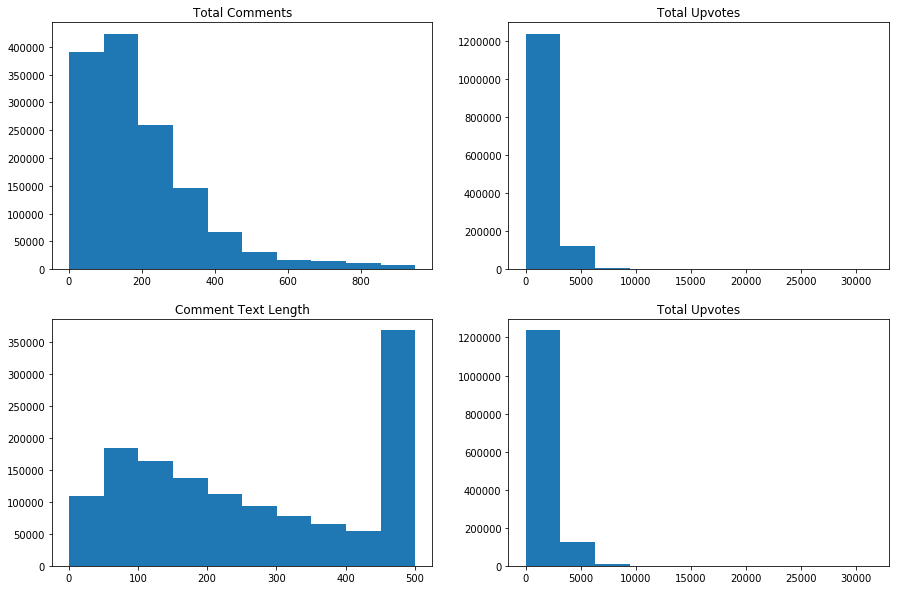

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].hist(co['total_comments'])
axes[0, 0].set_title('Total Comments')

axes[0, 1].hist(co['total_upvotes'])
axes[0, 1].set_title('Total Upvotes')

axes[1, 0].hist(np.clip(co['comment_text'].str.len(), 0, 500))
axes[1, 0].set_title('Comment Text Length')

axes[1, 1].hist(co['total_upvotes'])
axes[1, 1].set_title('Total Upvotes')